In [1]:
import warnings
warnings.filterwarnings("ignore")

import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split

# Prepare data & Set up training

In [2]:
ticker = "BTC-USD"
data = yf.download(ticker, start="2010-01-01", end=pd.Timestamp.now().strftime('%Y-%m-%d'), progress=False)
data = data["Close"][ticker].values

def create_sequences(data, seq_length):
    X, y = [], []
    for i in range(len(data) - seq_length):
        X.append(data[i: i + seq_length])
        y.append(data[i + seq_length])
    return np.array(X), np.array(y)

seq_length: int = 100
X, y = create_sequences(data, seq_length)

X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=False, test_size=0.2)
print(f"X_train.shape = {X_train.shape}")
print(f"X_test.shape = {X_test.shape}")

X_scaler = StandardScaler()
y_scaler = StandardScaler()

X_train = X_scaler.fit_transform(X_train)
X_test = X_scaler.transform(X_test)

y_train = y_scaler.fit_transform(y_train.reshape(-1, 1))
y_test = y_scaler.transform(y_test.reshape(-1, 1))

# Convert data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
match device.type:
    case "cuda":
        print(f"Device: {torch.cuda.get_device_name()}")
    case "cpu":
        print("Device: CPU")


BATCH_SIZE: int = 256

class MAPE(nn.Module):
    def __init__(self):
        super(MAPE, self).__init__()

    def forward(self, y_pred, y_true):
        epsilon = 1e-8  # Avoid division by zero
        return torch.mean(torch.abs((y_true - y_pred) / (y_true + epsilon))) * 100
    

def train_model(model, n_epochs: int = 10):
    criterion = MAPE()
    optimizer = optim.Adam(model.parameters(), lr=0.01)

    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=30, gamma=0.5)
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)

    loss_history = []
    for epoch in range(n_epochs):
        running_loss = 0
        for inputs, targets in train_loader:

            inputs, targets = inputs.to(device), targets.to(device)
            inputs = inputs.view(-1, seq_length, 1)
            targets = targets.view(-1, 1)

            # Zero gradients
            optimizer.zero_grad()

            # Forward pass
            output = model(inputs)
            loss = criterion(output, targets)

            # Backprop
            loss.backward()
            
            # Grad clipping
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()
            
            running_loss += loss.item()

        scheduler.step()
        avg_loss = running_loss / len(train_loader)
        loss_history.append(avg_loss)

        if epoch % 10 == 0 or epoch + 1 == n_epochs:
            print(f"Epoch {epoch + 1}/{n_epochs}, Loss: {avg_loss:.6f}")
    
    return loss_history

N_DAYS: int = 100

def forecast(model):
    last_sequence = y_train[-seq_length:].reshape(-1, 1)
    predictions = []
    current_seq = last_sequence.copy()
    for _ in range(N_DAYS):
        next_pred = model(torch.tensor(current_seq.reshape(1, seq_length, 1), dtype=torch.float32).to(device))
        predictions.append(next_pred.item())
        current_seq = np.append(current_seq[1:], next_pred.item())

    return predictions

def create_plots(test_predictions, loss_history):
    plt.figure(figsize=(7, 5))
    plt.plot(test_predictions, label='Predictions', color='blue')
    plt.plot(y_test[:N_DAYS], label='Real Values', color='orange')
    plt.title('Predictions vs Real Values (scaled)')
    plt.xlabel('Day')
    plt.ylabel('Value')
    plt.legend()
    plt.show()

    plt.figure(figsize=(7, 5))
    plt.plot(loss_history, label='Loss History', color='green')
    plt.title('Training Loss History')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.show()

X_train.shape = (2962, 100)
X_test.shape = (741, 100)
Device: NVIDIA GeForce RTX 4060


# RNN

Epoch 1/100, Loss: 80.157691
Epoch 11/100, Loss: 11.694237
Epoch 21/100, Loss: 8.646837
Epoch 31/100, Loss: 10.556082
Epoch 41/100, Loss: 5.947554
Epoch 51/100, Loss: 5.848509
Epoch 61/100, Loss: 5.761109
Epoch 71/100, Loss: 5.604815
Epoch 81/100, Loss: 5.654030
Epoch 91/100, Loss: 5.167552
Epoch 100/100, Loss: 5.544031


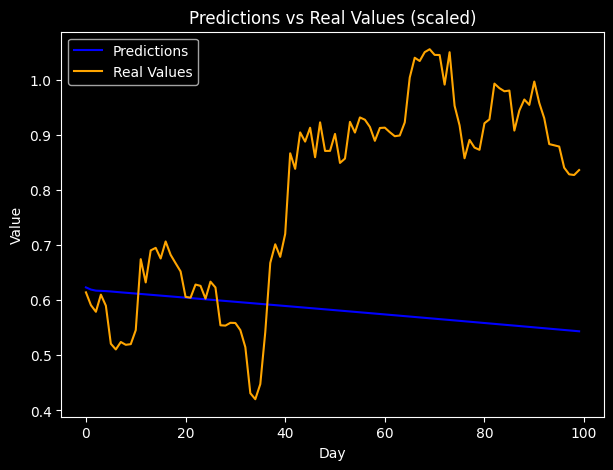

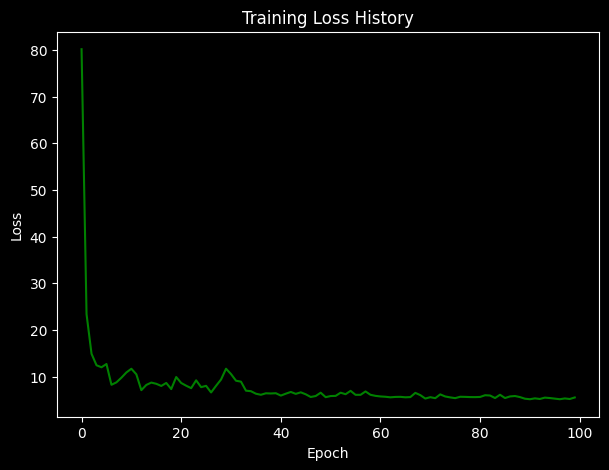

In [3]:
class RNNModel(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(RNNModel, self).__init__()
        self.hidden_size = hidden_size
        self.rnn = nn.RNN(input_size, hidden_size, batch_first=True, nonlinearity="relu")
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        h0 = torch.zeros(1, x.size(0), self.hidden_size).to(x.device)
        out, _ = self.rnn(x, h0)
        out = self.fc(out[:, -1, :])
        return out

rnn_model = RNNModel(input_size=1, hidden_size=32).to(device)
loss_history = train_model(rnn_model, n_epochs=100)

predictions = forecast(rnn_model)
create_plots(predictions, loss_history)

# LSTM

Epoch 1/100, Loss: 93.647174
Epoch 11/100, Loss: 15.411646
Epoch 21/100, Loss: 10.606326
Epoch 31/100, Loss: 7.112900
Epoch 41/100, Loss: 7.406016
Epoch 51/100, Loss: 7.426729
Epoch 61/100, Loss: 6.655927
Epoch 71/100, Loss: 6.421900
Epoch 81/100, Loss: 6.533347
Epoch 91/100, Loss: 6.431365
Epoch 100/100, Loss: 6.336705


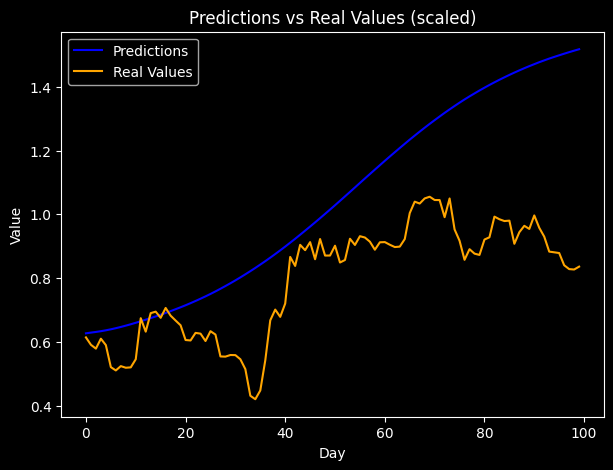

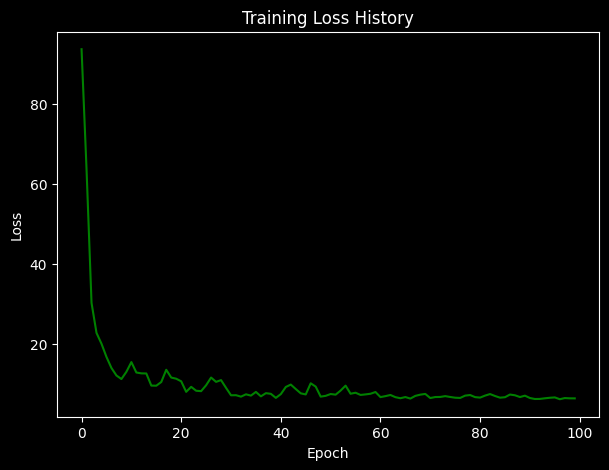

In [4]:
class LSTM(nn.Module):
    def __init__(self, input_size = 1, hidden_size = 128, num_layers = 4):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(
            input_size = input_size,
            hidden_size = hidden_size,
            num_layers = num_layers,
            batch_first = True
        )
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).requires_grad_().to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).requires_grad_().to(device)
        out, (hn, cn) = self.lstm(x, (h0.detach(), c0.detach()))
        out = self.fc(out[:, -1, :])
        return out


lstm_model = LSTM(input_size=1, hidden_size=16, num_layers=2).to(device)
loss_history = train_model(lstm_model, n_epochs=100)
predictions = forecast(lstm_model)
create_plots(predictions, loss_history)

# GRU

Epoch 1/100, Loss: 65.498907
Epoch 11/100, Loss: 15.650129
Epoch 21/100, Loss: 10.152410
Epoch 31/100, Loss: 10.929906
Epoch 41/100, Loss: 8.093044
Epoch 51/100, Loss: 7.273444
Epoch 61/100, Loss: 6.734956
Epoch 71/100, Loss: 6.144773
Epoch 81/100, Loss: 6.144638
Epoch 91/100, Loss: 5.421966
Epoch 100/100, Loss: 5.552545


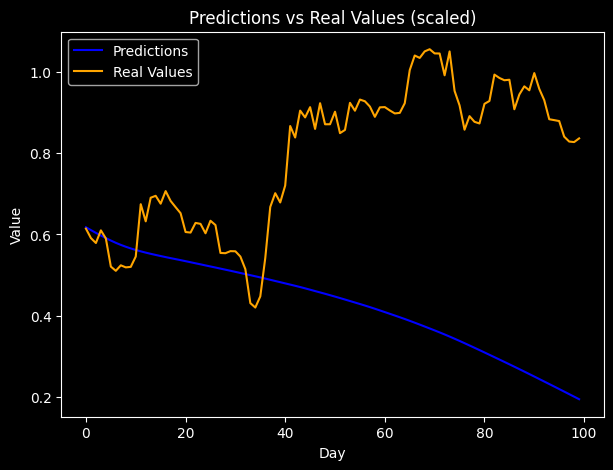

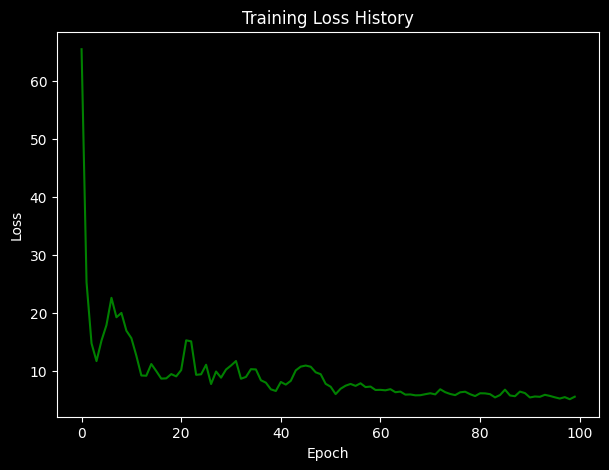

In [5]:
class GRU(nn.Module):
    def __init__(self, input_size = 1, hidden_size = 64, num_layers = 2):
        super(GRU, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.gru = nn.GRU(
            input_size = input_size,
            hidden_size = hidden_size,
            num_layers = num_layers,
            batch_first = True
        )
        self.fc = nn.Linear(hidden_size, 1)
        
    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).requires_grad_().to(device)
        out, hn = self.gru(x, h0.detach())
        out = self.fc(out[:, -1, :])
        return out

gru_model = GRU(input_size=1, hidden_size=64).to(device)
loss_history = train_model(gru_model, n_epochs=100)
predictions = forecast(gru_model)
create_plots(predictions, loss_history)

# Why predictions are poor:

1. MSE Loss clearly indicates that the model becomes overfitted rapidly. Though the architecture used is quite simple, it's enough to learn the data. To address this issue, one should collect a bigger dataset.

2. MSE is not entirely appropriate here because Bitcoin is highly volatile. One day its price could be $1, and another day it could be $70,000. For this reason, it is more reasonable to use MAPE (as a loss function).

3. Price is determined by external factors such as market pressure. It's impossible to predict the price of the derivative by only looking at its price history.

4. Errors in code:

   - Scaling was applied before splitting the dataset into train/test, which led to data leakage. **Solution:** First split, then use 
     ```python
     train.fit_transform()
     test.transform()
     ```

   - Predictions were compared with the wrong data:
     ```python
     last_sequence = scaled_data[-seq_length:].reshape(-1, 1)
     ```
     should be:
     ```python
     last_sequence = y_train[-seq_length:].reshape(-1, 1)
     ```

5. Accumulation error: Each next prediction is based on the previous predictions, which in turn contain biases.
